In [ ]:
import pandas as pd
# Montar Google Drive para acceder a los archivos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Tablas_finales

/content/drive/MyDrive/Tablas_finales


In [ ]:
df_final = pd.read_csv('Tabla_final_LTV.csv')

<ipython-input-40-e954d7e50cab>:1: DtypeWarning: Columns (28,39,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv('Tabla_final_LTV.csv')


In [ ]:
print(df_final.columns)

Index(['month', 'product_id', 'order_id', 'order_name', 'variant_sku',
       'financial_status', 'customer_id', 'referrer_source',
       'referring_channel', 'referring_traffic', 'shipping_region',
       'referring_category', 'referrer_path', 'utm_campaign_content',
       'utm_campaign_medium', 'utm_campaign_name', 'utm_campaign_source',
       'utm_campaign_term', 'sale_line_type', 'sale_kind', 'orders',
       'gross_sales', 'discounts', 'returns', 'net_sales', 'shipping', 'taxes',
       'total_sales', 'Customer ID', 'Email', 'Accepts Email Marketing',
       'Default Address Address1', 'Default Address Address2',
       'Default Address City', 'Default Address Province Code',
       'Default Address Zip', 'Default Address Phone', 'Phone',
       'Accepts SMS Marketing', 'Total Spent', 'Total Orders', 'full name',
       'Compras', 'product_title', 'product_type', 'variant_id',
       'variant_title'],
      dtype='object')


In [ ]:
df_final['total_sales'] = pd.to_numeric(df_final['total_sales'], errors='coerce')
frequency = df_final.groupby('customer_id')['order_name'].nunique().reset_index()
frequency.columns = ['customer_id', 'purchase_frequency']
df_metricas = df_final.groupby('customer_id').agg(
    full_name=('full name', 'first'),
    product_type=('product_type', 'first'),
    financial_status=('financial_status', 'first'),
    num_products=('order_name', 'count'),
    total_sales=('total_sales', 'sum')
).reset_index()
result = pd.merge(df_metricas, frequency, on='customer_id')
result.head()
filtered_result = result[result['purchase_frequency'] > 1]
filtered_result.head()


,customer_id,full_name,product_type,financial_status,num_products,total_sales,purchase_frequency
0,2799265480800,carlos ossa,linternas,voided,5,47475,3
1,2945859321952,Baltazar Drapela,plato,voided,6,0,3
6,2947679158368,Tomas Ureta,vasos térmicos,paid,4,59764,3
7,2947683778656,Tomas Ureta,pantuflas,paid,3,28588,2
8,2947723853920,Ismael Ovalle,test,paid,6,1150,2


In [ ]:
df_agrupado = df_final.groupby('order_name').agg(
    month=('month', 'first'),
    customer_id=('customer_id', 'first'),
    full_name=('full name', 'first'),
    total_sales_sum=('total_sales', 'sum')
).reset_index()
df_agrupado.head()

df_agrupado['month'] = pd.to_datetime(df_agrupado['month'])
df_agrupado = df_agrupado.sort_values(by=['customer_id', 'month'])


df_agrupado['previous_purchase_date'] = df_agrupado.groupby('customer_id')['month'].shift(1)
df_agrupado['days_since_last_purchase'] = (df_agrupado['month'] - df_agrupado['previous_purchase_date']).dt.days

df_agrupado = df_agrupado.dropna(subset=['days_since_last_purchase'])
df_agrupado.head(1000)

promedio_dias = df_agrupado['days_since_last_purchase'].mean()
"El promedio de días entre compras consecutivas es:", promedio_dias

('El promedio de días entre compras consecutivas es:', 181.01872246696036)

LTV

In [ ]:
df= df_final.groupby(['month', 'customer_id', 'full name', 'Email', 'sale_line_type', 'sale_kind', 'order_name']).agg(
    total_sales_sum=('total_sales', 'sum'),
    product_count=('total_sales', 'size')
).reset_index()
df.rename(columns={'total_sales_sum': 'total_sales', 'product_count': 'cantidad'}, inplace=True)
ventas_conteo_productos = df.drop(columns=['product_type', 'product_title'], errors='ignore')
ventas_conteo_productos

,month,customer_id,full name,Email,sale_line_type,sale_kind,order_name,total_sales,cantidad
0,2020-01-01,2945859321952,Baltazar Drapela,bdrapela@uc.cl,product,order,#1002,7990,1
1,2020-01-01,2945859321952,Baltazar Drapela,bdrapela@uc.cl,product,return,#1002,-7990,1
2,2020-01-01,2946064056416,Jose Pérez,josperez@hotmail.es,product,order,#1003,47980,2
3,2020-01-01,2946196013152,Pastora Parragué,pastoraparrague@gmail.com,product,order,#1004,26392,1
4,2020-01-01,2946384658528,Paola Molina Salgado,paomsalgado@hotmail.com,product,order,#1005,23394,1
...,...,...,...,...,...,...,...,...,...
34400,2024-04-01,7358219944171,Desconocido,Desconocido,product,order,AO-34370,46980,2
34401,2024-04-01,7358235738347,Desconocido,Desconocido,product,order,AO-34371,14990,1
34402,2024-04-01,7358291345643,Desconocido,Desconocido,product,order,AO-34374,32990,1
34403,2024-04-01,7358325915883,Desconocido,Desconocido,product,order,AO-34375,26990,1


In [ ]:
df['month'] = pd.to_datetime(df['month'])
df['order_count'] = df.groupby('order_name')['order_name'].transform('count')
df.head(5)

,month,customer_id,full name,Email,sale_line_type,sale_kind,order_name,total_sales,cantidad,order_count
0,2020-01-01,2945859321952,Baltazar Drapela,bdrapela@uc.cl,product,order,#1002,7990,1,2
1,2020-01-01,2945859321952,Baltazar Drapela,bdrapela@uc.cl,product,return,#1002,-7990,1,2
2,2020-01-01,2946064056416,Jose Pérez,josperez@hotmail.es,product,order,#1003,47980,2,1
3,2020-01-01,2946196013152,Pastora Parragué,pastoraparrague@gmail.com,product,order,#1004,26392,1,1
4,2020-01-01,2946384658528,Paola Molina Salgado,paomsalgado@hotmail.com,product,order,#1005,23394,1,1


In [ ]:
from datetime import timedelta

In [ ]:
df['month'] = pd.to_datetime(df['month'])

# Calculamos la fecha más reciente de cada cliente
last_purchase_date = df.groupby('customer_id')['month'].max()
days_window = 365
# Calculamos fecha límite del período de tiempo
end_date = last_purchase_date - timedelta(days=days_window)
df_filtered = df[df['month'] >= end_date[df['customer_id']].values]
# Calculamos Recency
recency = df_filtered.groupby('customer_id')['month'].max()
# Calculamos Frequency
frequency = df_filtered.groupby('customer_id')['order_count'].sum()
# Calculamos Monetary
monetary = df_filtered.groupby('customer_id')['total_sales'].sum()
rfm = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'monetary_value': monetary
})
# Calculamos fecha actual
current_date = df['month'].max()
# Calculamos la diferencia en días entre la fecha más reciente de compra y la fecha actual
rfm['Recencia'] = (current_date - rfm['Recency']).dt.days
refm.head()

                 Recency  Frequency  monetary_value  Recencia
customer_id                                                  
2799265480800 2021-12-01          6           47475       852
2945859321952 2023-10-01          4               0       183
2946064056416 2020-01-01          1           47980      1552
2946196013152 2020-01-01          1           26392      1552
2946384658528 2020-01-01          1           23394      1552
...                  ...        ...             ...       ...
7358219944171 2024-04-01          1           46980         0
7358235738347 2024-04-01          1           14990         0
7358291345643 2024-04-01          1           32990         0
7358325915883 2024-04-01          1           26990         0
7358353375467 2024-04-01          1           61960         0

[24287 rows x 4 columns]


In [ ]:
# Última fecha disponible en los datos
last_date = df['month'].max()
rfm = df.groupby('customer_id').agg({
    'month': lambda x: (last_date - x.max()).days,
    'order_name': 'nunique',
    'total_sales': 'sum'
}).rename(columns={'month': 'recency', 'order_name': 'frequency', 'total_sales': 'monetary_value'})

# Revisar los datos de RFM
rfm.head()

,recency,frequency,monetary_value
customer_id,,,
2799265480800,852,3,47475
2945859321952,183,3,0
2946064056416,1552,1,47980
2946196013152,1552,1,26392
2946384658528,1552,1,23394


In [ ]:
# Segmentar recencia, frecuencia y valor monetario en tres grupos
rfm['R_score'] = pd.cut(rfm['recency'], bins=3, labels=[3, 2, 1])
rfm['F_score'] = pd.cut(rfm['frequency'], bins=3, labels=[1, 2, 3])
rfm['M_score'] = pd.cut(rfm['monetary_value'], bins=3, labels=[1, 2, 3])

# Calculamos puntuación total RFM
rfm['RFM_score'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)
total_sales = df['total_sales'].sum()
total_orders = df['order_name'].nunique()
average_order_value = total_sales / total_orders
# Calculamos frecuencia de compra promedio
total_customers = df['customer_id'].nunique()
average_purchase_frequency = total_orders / total_customers
# Calculamos valor del cliente
customer_value = average_order_value * average_purchase_frequency
# Estimar la vida útil promedio del cliente (en años, si es posible estimarla)
# Aquí asumiremos una vida útil promedio de 2 años como ejemplo
average_customer_lifespan = 1
# Calcular el valor de vida del cliente (CLV)
CLV = customer_value * average_customer_lifespan
rfm.head(), average_order_value, average_purchase_frequency, customer_value, CLV

(               recency  frequency  monetary_value R_score F_score M_score  \
 customer_id                                                                 
 2799265480800      852          3           47475       2       1       1   
 2945859321952      183          3               0       3       1       1   
 2946064056416     1552          1           47980       1       1       1   
 2946196013152     1552          1           26392       1       1       1   
 2946384658528     1552          1           23394       1       1       1   
 
                RFM_score  
 customer_id               
 2799265480800          4  
 2945859321952          5  
 2946064056416          3  
 2946196013152          3  
 2946384658528          3  ,
 35915.20933856805,
 1.3738625602174002,
 49342.56145262898,
 49342.56145262898)

In [ ]:
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')
first_purchase = df.groupby('customer_id')['month'].min()
last_purchase = df.groupby('customer_id')['month'].max()
customer_lifetime = (last_purchase - first_purchase).dt.days
average_customer_lifespan_days = customer_lifetime.mean()
average_customer_lifespan_years = average_customer_lifespan_days / 365
average_customer_lifespan_years

0.18627689090110217

In [ ]:
# Calcular el valor promedio del pedido para cada cliente
rfm['average_order_value'] = rfm['monetary_value'] / rfm['frequency']
# Calcular el valor del cliente para cada cliente
rfm['customer_value'] = rfm['average_order_value'] * rfm['frequency']
# Calcular el CLV individual para cada cliente utilizando la vida útil promedio calculada previamente
rfm['CLV'] = rfm['customer_value'] * average_customer_lifespan_years
rfm[['average_order_value', 'frequency', 'customer_value', 'CLV']].head()

,average_order_value,frequency,customer_value,CLV
customer_id,,,,
2799265480800,15825.0,3,47475.0,8843.495396
2945859321952,0.0,3,0.0,0.000000
2946064056416,47980.0,1,47980.0,8937.565225
2946196013152,26392.0,1,26392.0,4916.219705
2946384658528,23394.0,1,23394.0,4357.761586


In [ ]:
RFMP = rfm[['average_order_value', 'frequency', 'customer_value', 'CLV']]

In [ ]:
rfm.reset_index(inplace=True)

In [ ]:
rfm.head()

,customer_id,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,average_order_value,customer_value,CLV
0,2799265480800,852,3,47475,2,1,1,4,15825.0,47475.0,8843.495396
1,2945859321952,183,3,0,3,1,1,5,0.0,0.0,0.000000
2,2946064056416,1552,1,47980,1,1,1,3,47980.0,47980.0,8937.565225
3,2946196013152,1552,1,26392,1,1,1,3,26392.0,26392.0,4916.219705
4,2946384658528,1552,1,23394,1,1,1,3,23394.0,23394.0,4357.761586


In [ ]:
rfm[rfm['monetary_value'] == 0]

,customer_id,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,average_order_value,customer_value,CLV
1,2945859321952,183,3,0,3,1,1,5,0.0,0.0,0.0
5,2946390949984,183,1,0,3,1,1,5,0.0,0.0,0.0
105,3007989022816,1492,1,0,1,1,1,3,0.0,0.0,0.0
145,3020780929120,1492,1,0,1,1,1,3,0.0,0.0,0.0
228,3061743190112,1492,1,0,1,1,1,3,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
23801,7311320580331,0,1,0,3,1,1,5,0.0,0.0,0.0
23831,7318588719339,0,1,0,3,1,1,5,0.0,0.0,0.0
23856,7320978030827,0,1,0,3,1,1,5,0.0,0.0,0.0
23981,7328814596331,0,1,0,3,1,1,5,0.0,0.0,0.0


In [ ]:
# Definir los segmentos
rfm['RFM_Segment'] = pd.cut(rfm['RFM_score'], bins=3, labels=['Bajo', 'Medio', 'Alto'])
rfm[['RFM_score', 'RFM_Segment']].head()


   RFM_score RFM_Segment
0          4        Bajo
1          5       Medio
2          3        Bajo
3          3        Bajo
4          3        Bajo


In [ ]:
# Definir los segmentos basados en CLV
rfm['CLV_Segment'] = pd.cut(rfm['CLV'], bins=3, labels=['Bajo', 'Medio', 'Alto'])
rfm[['CLV', 'CLV_Segment']].head()

           CLV CLV_Segment
0  8843.495396        Bajo
1     0.000000        Bajo
2  8937.565225        Bajo
3  4916.219705        Bajo
4  4357.761586        Bajo


In [ ]:
rfm['Quadrant'] = 'NA'
rfm.loc[(rfm['RFM_score'] > rfm['RFM_score'].median()) & (rfm['CLV'] > rfm['CLV'].median()), 'Segmento'] = 'High Value'
rfm.loc[(rfm['RFM_score'] > rfm['RFM_score'].median()) & (rfm['CLV'] <= rfm['CLV'].median()), 'Segmento'] = 'High RFM, Low CLV'
rfm.loc[(rfm['RFM_score'] <= rfm['RFM_score'].median()) & (rfm['CLV'] > rfm['CLV'].median()), 'Segmento'] = 'Low RFM, High CLV'
rfm.loc[(rfm['RFM_score'] <= rfm['RFM_score'].median()) & (rfm['CLV'] <= rfm['CLV'].median()), 'Segmento'] = 'Low Value'
rfm[['customer_id','RFM_score', 'CLV', 'Segmento']].head()

,customer_id,RFM_score,CLV,Segmento
0,2799265480800,4,8843.495396,"Low RFM, High CLV"
1,2945859321952,5,0.000000,"High RFM, Low CLV"
2,2946064056416,3,8937.565225,"Low RFM, High CLV"
3,2946196013152,3,4916.219705,Low Value
4,2946384658528,3,4357.761586,Low Value


In [ ]:
rfm.head()

,customer_id,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,average_order_value,customer_value,CLV,RFM_Segment,CLV_Segment,Quadrant,Segmento
0,2799265480800,852,3,47475,2,1,1,4,15825.0,47475.0,8843.495396,Bajo,Bajo,NA,"Low RFM, High CLV"
1,2945859321952,183,3,0,3,1,1,5,0.0,0.0,0.000000,Medio,Bajo,NA,"High RFM, Low CLV"
2,2946064056416,1552,1,47980,1,1,1,3,47980.0,47980.0,8937.565225,Bajo,Bajo,NA,"Low RFM, High CLV"
3,2946196013152,1552,1,26392,1,1,1,3,26392.0,26392.0,4916.219705,Bajo,Bajo,NA,Low Value
4,2946384658528,1552,1,23394,1,1,1,3,23394.0,23394.0,4357.761586,Bajo,Bajo,NA,Low Value


In [ ]:
ruta_destino = '/content/drive/MyDrive/Tablas_finales/RFMFINAL.csv'
rfm.to_csv(ruta_destino, index=False)

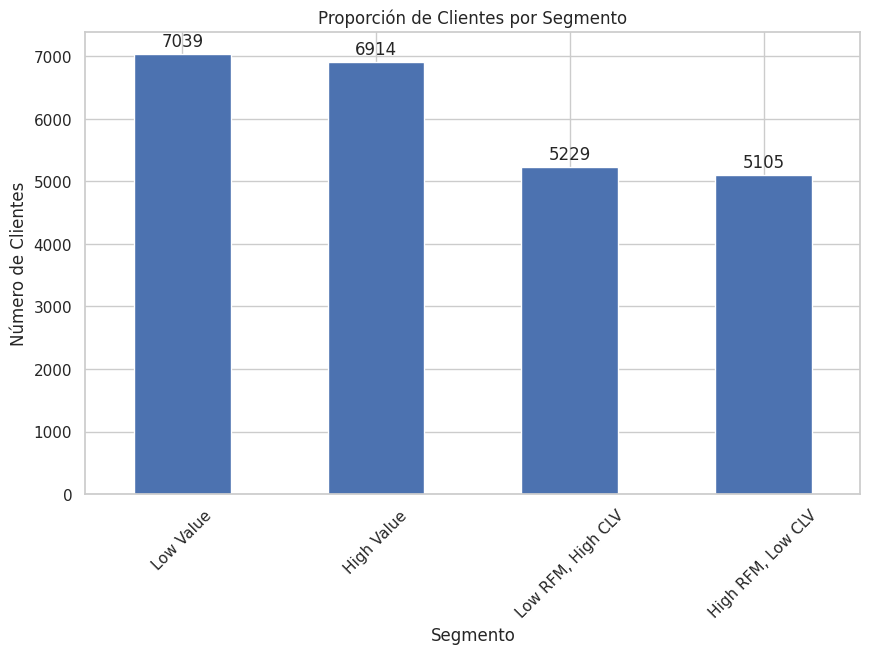

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(rfm)

sns.set(style="whitegrid")

# Proporción de Clientes por Segmento
plt.figure(figsize=(10, 6))
bar_plot = df['Segmento'].value_counts().plot(kind='bar')
plt.title('Proporción de Clientes por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)

# Añadir etiquetas de datos
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

plt.show()

In [ ]:
df_final = df_final.merge(rfm[['customer_id', 'Segmento']], on='customer_id', how='left')

In [ ]:
# Ventas totales por cada uno de los grupos
ventas_por_segmento = df_final.groupby('Segmento')['total_sales'].sum().reset_index()
ventas_por_segmento.columns = ['Segmento', 'Ventas Totales']

In [ ]:
# Número de órdenes por cada segmento
ordenes_por_segmento = df_final.groupby('Segmento')['order_id'].nunique().reset_index()
ordenes_por_segmento.columns = ['Segmento', 'Número de Órdenes']

In [ ]:
# Filtrar los top 3 regiones por número de clientes
top_regions = df_final['shipping_region'].value_counts().nlargest(3).index
df_top_regions = df_final[df_final['shipping_region'].isin(top_regions)]

In [ ]:
# Top 3 categorías de productos por cada segmentación
top_categorias_por_segmento = df_final.groupby(['Segmento', 'product_type'])['total_sales'].sum().reset_index()
top_categorias_por_segmento = top_categorias_por_segmento.sort_values(['Segmento', 'total_sales'], ascending=[True, False])
top_categorias_por_segmento = top_categorias_por_segmento.groupby('Segmento').head(3)

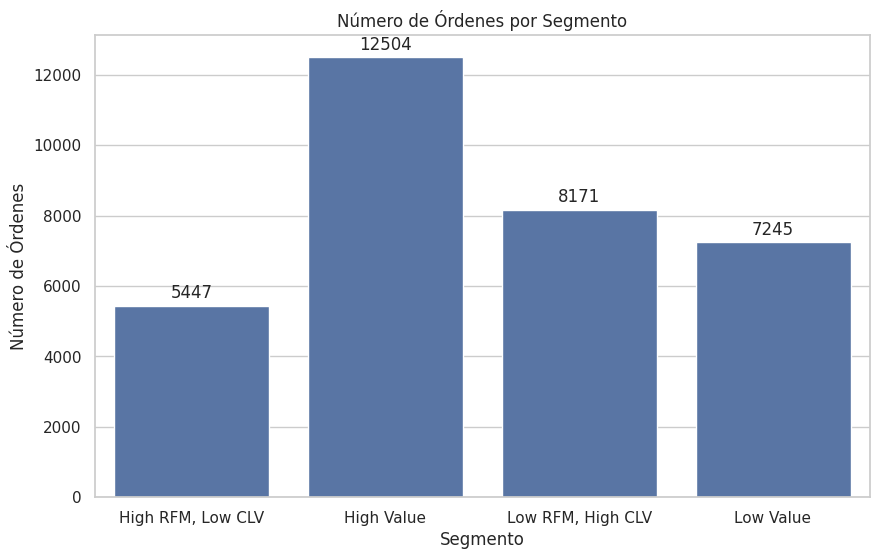

In [ ]:
# Número de Órdenes por Segmento
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=ordenes_por_segmento, x='Segmento', y='Número de Órdenes')
plt.title('Número de Órdenes por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Número de Órdenes')
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')
plt.show()

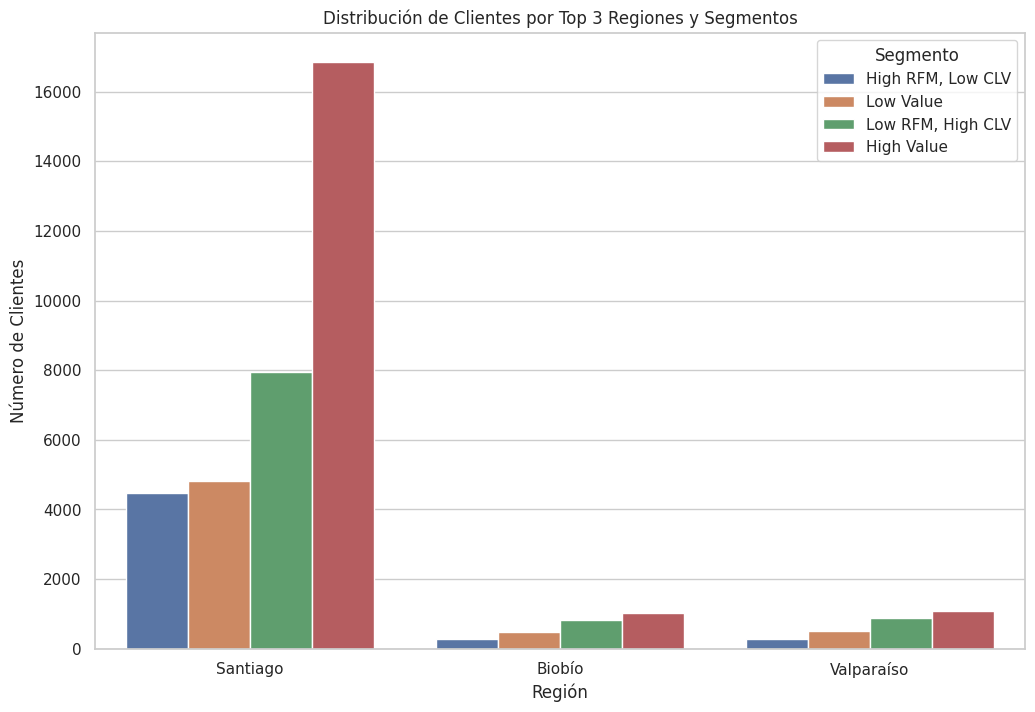

In [ ]:
# Crear un gráfico de la distribución de clientes por regiones y segmentos
plt.figure(figsize=(12, 8))
sns.countplot(data=df_top_regions, x='shipping_region', hue='Segmento')
plt.title('Distribución de Clientes por Top 3 Regiones y Segmentos')
plt.xlabel('Región')
plt.ylabel('Número de Clientes')
plt.legend(title='Segmento')
plt.show()

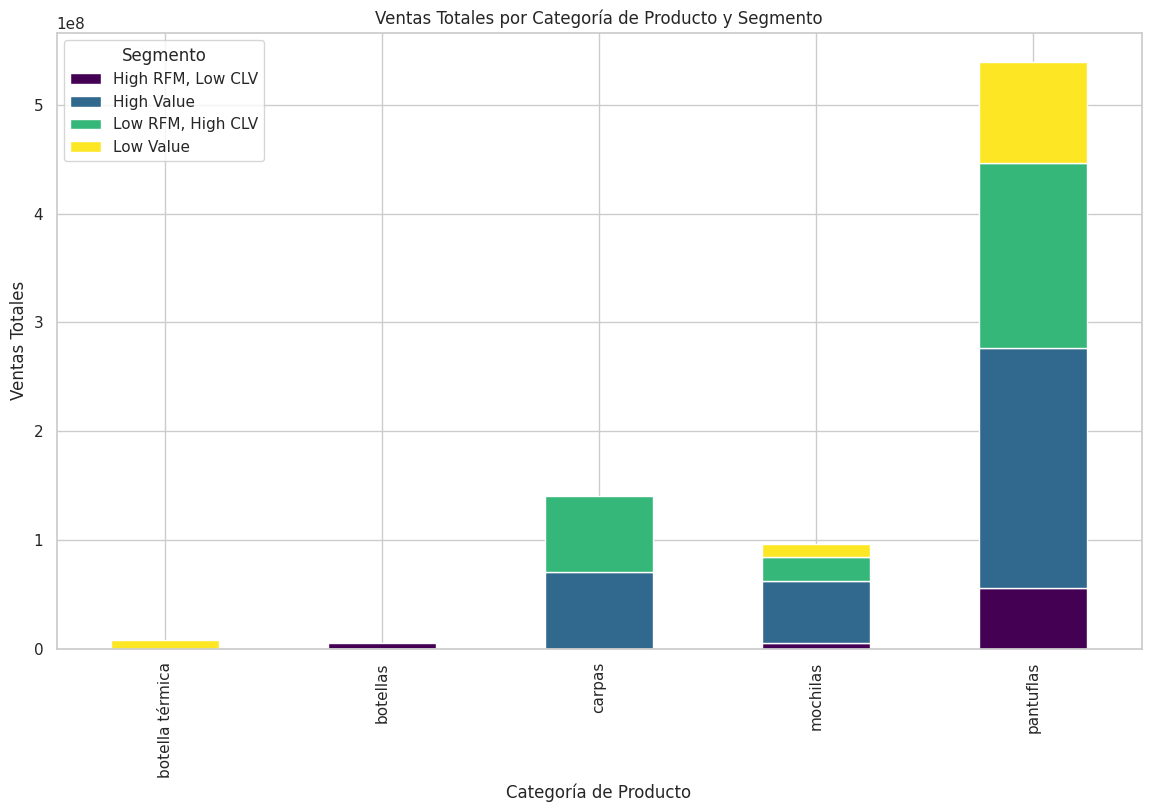

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenemos los segmentos únicos
segmentos = top_categorias_por_segmento['Segmento'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(segmentos), figsize=(20, 6), sharey=True)

for ax, segmento in zip(axes, segmentos):
    top_categorias = top_categorias_por_segmento[top_categorias_por_segmento['Segmento'] == segmento]
    bar_plot = sns.barplot(data=top_categorias, x='product_type', y='total_sales', ax=ax)
    ax.set_title(f'Top 3 Categorías de Productos: {segmento}')
    ax.set_xlabel('Categoría de Producto')
    ax.set_ylabel('Ventas Totales' if ax == axes[0] else '')

    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.2f'),
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center',
                          xytext=(0, 9),
                          textcoords='offset points')
plt.tight_layout()
plt.show()

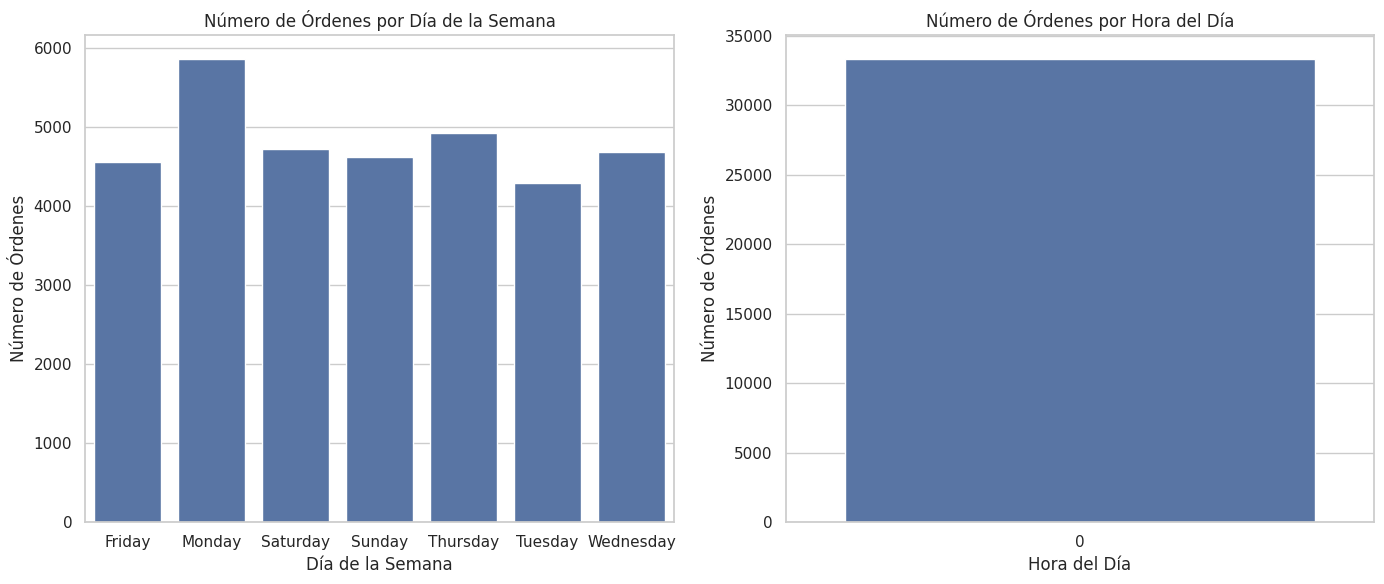

In [ ]:
df_final['month'] = pd.to_datetime(df_final['month'])

# Extraer día de la semana y hora del día
df_final['day_of_week'] = df_final['month'].dt.day_name()
df_final['hour_of_day'] = df_final['month'].dt.hour

# Número de órdenes por día de la semana
orders_by_day = df_final.groupby('day_of_week')['order_id'].nunique().reset_index()
orders_by_day.columns = ['day_of_week', 'number_of_orders']

# Número de órdenes por hora del día
orders_by_hour = df_final.groupby('hour_of_day')['order_id'].nunique().reset_index()
orders_by_hour.columns = ['hour_of_day', 'number_of_orders']

# Graficar los resultados
plt.figure(figsize=(14, 6))

# Órdenes por día de la semana
plt.subplot(1, 2, 1)
sns.barplot(data=orders_by_day, x='day_of_week', y='number_of_orders')
plt.title('Número de Órdenes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Órdenes')

# Órdenes por hora del día
plt.subplot(1, 2, 2)
sns.barplot(data=orders_by_hour, x='hour_of_day', y='number_of_orders')
plt.title('Número de Órdenes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Órdenes')

plt.tight_layout()
plt.show()


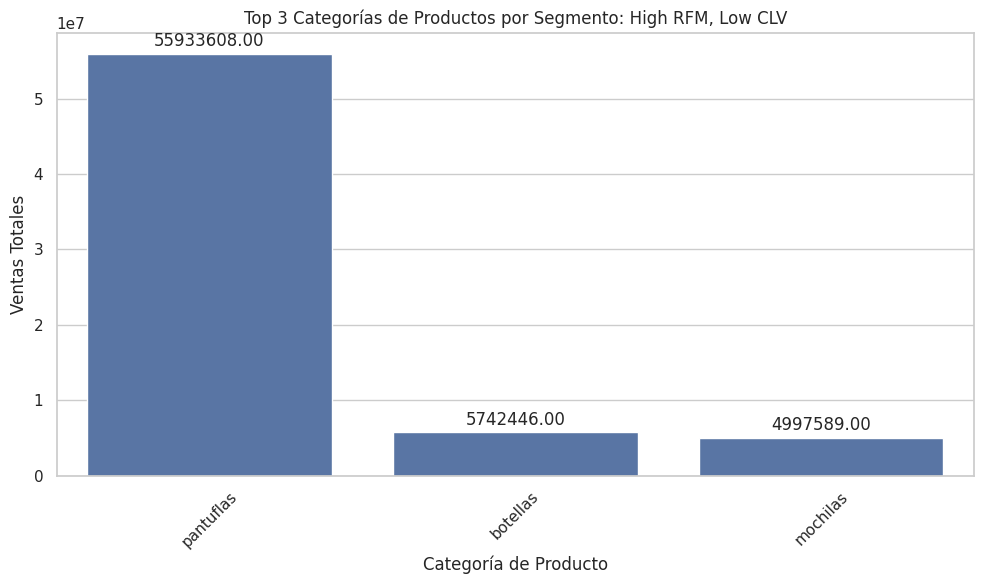

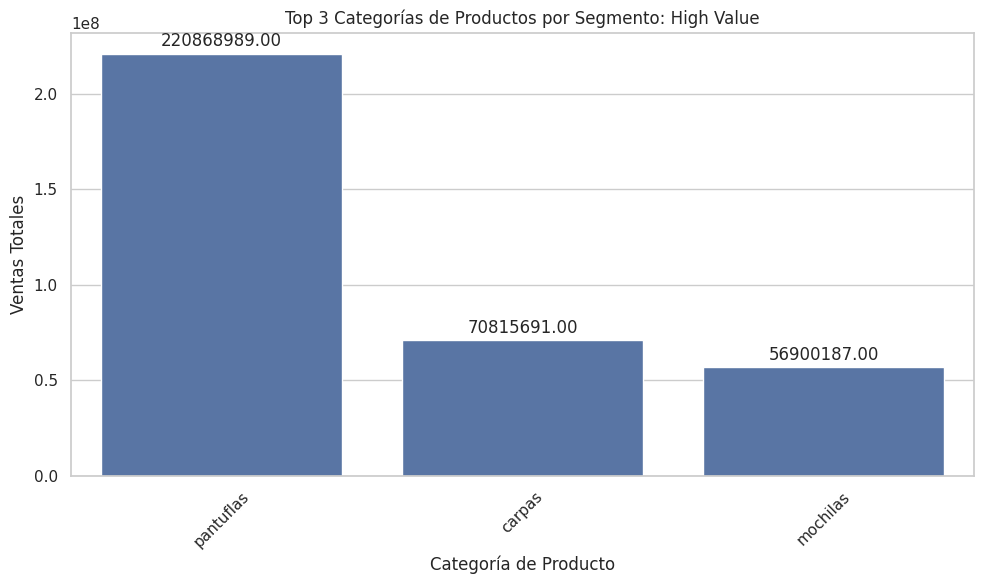

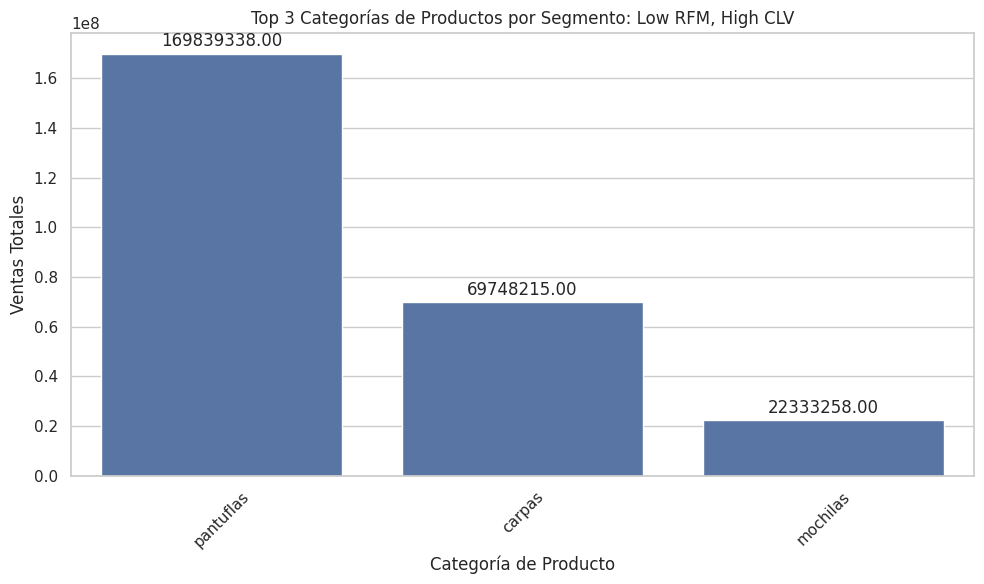

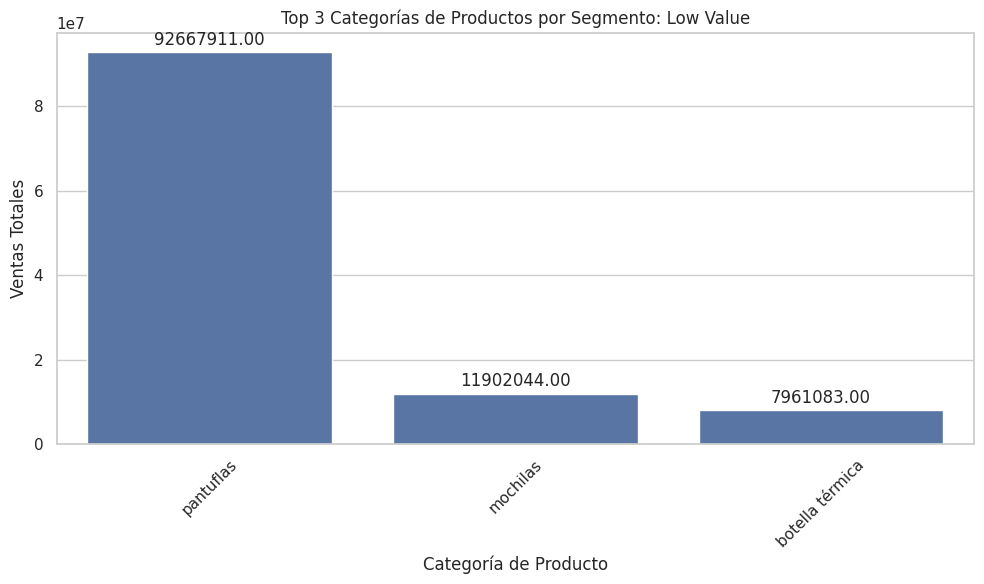

In [ ]:
# Obtener el top 3 de categorías de productos por segmento
top_categorias_por_segmento = df_final.groupby(['Segmento', 'product_type'])['total_sales'].sum().reset_index()
top_categorias_por_segmento = top_categorias_por_segmento.sort_values(['Segmento', 'total_sales'], ascending=[True, False])
top_categorias_por_segmento = top_categorias_por_segmento.groupby('Segmento').head(3)

# Visualización del top 3 de categorías de productos por segmento
for segmento in top_categorias_por_segmento['Segmento'].unique():
    top_categorias = top_categorias_por_segmento[top_categorias_por_segmento['Segmento'] == segmento]
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(data=top_categorias, x='product_type', y='total_sales')
    plt.title(f'Top 3 Categorías de Productos por Segmento: {segmento}')
    plt.xlabel('Categoría de Producto')
    plt.ylabel('Ventas Totales')
    plt.xticks(rotation=45)
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.2f'),
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center',
                          xytext=(0, 9),
                          textcoords='offset points')
    plt.tight_layout()
    plt.show()

